# PeakSwift: Analysis of Accuracy through Comparison towards Neurokit

This notebook presents an analysis of the PeakSwift package's capabilities in detecting R-peaks and assessment of signal quality within single-lead electrocardiogram signals. The evaluation is conducted against the established gold standard, NeuroKit. The analysis encompasses the thorough assessment and validation of the following key aspects:

- Accuracy of R-peak detection
- Performance in signal quality assessment
- Computational runtime efficiency

Through this analysis, we aim to provide a deeper understanding of the PeakSwift package's utility and effectiveness in comparison to a recognized standard. Additionally, the computational runtime is scrutinized to gauge the efficiency of the package in real-world applications.

In [1]:
import glob
import json
import time
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import neurokit2 as nk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import session_info
session_info.show()

ModuleNotFoundError: No module named 'session_info'

### Data Loading

The JSON-formatted exported data from the PeakWatch demo application must be located within the './data' directory.

In [111]:
def load_data(path="./data/*.json"):
    files = glob.glob(path)
    df = pd.DataFrame()
    events = pd.DataFrame()
    for k in files:
        f = json.load(open(k))
        df = pd.concat([df, pd.json_normalize(f['ecgs'])])
    df = df.reset_index()
    return df

Every row within the dataset corresponds to a 30-second electrocardiogram (ECG) recording, indicated in the 'ecg.ecg' column. Accompanying this primary data are essential metadata, including bpm, sampling rate, and date of recording. Additionally, PeakSwift's computed properties are included:

- R-peaks, computed through eight distinct detection algorithms
- Signal quality assessment, performed by two distinct algorithms

In [116]:
df = load_data()
df_os = load_data("./data/open-source/*.json")

In [5]:
df.head(1)

,index


In [6]:
plt.figure(figsize=(15, 5))
plt.plot(df['ecg.ecg'][43][2000:3536], c='royalblue')
plt.axis('off')
plt.savefig('./results/sample_ecg.png', bbox_inches='tight', dpi=300)
#plt.close()

KeyError: 'ecg.ecg'

<Figure size 1500x500 with 0 Axes>

In [7]:
# Watch6,2 : Apple Watch Series 6 44mm case (GPS)
# Watch6,1 : Apple Watch Series 6 40mm case (GPS)
# Watch5,2 : Apple Watch Series 5 44mm case (GPS)

print('Watch Model:', df['apple_meta_data.hardware_version'].unique())

df['timestamp_recording'] = pd.to_datetime(df['apple_meta_data.recording_start_time'] + 978307200, unit='s')
df['subject'] = pd.factorize(df['device_id'])[0]

KeyError: 'apple_meta_data.hardware_version'

In [113]:
print('Total amount of self-recorded ECG:', len(df))
print('Total amount of open-source ECG:', len(df_os))

Total amount of self-recorded ECG: 0
Total amount of open-source ECG: 10646


In [9]:
df.groupby('subject')['subject'].count()

KeyError: 'subject'

In [10]:
palette = sns.color_palette('tab10')
fig = plt.figure(figsize=(15,5))
plt.set_cmap('tab10')
ax = sns.histplot(data=df, x="timestamp_recording", hue="subject", bins=100, palette=palette)
ax.set(xlabel='Timestamp', ylabel='Number of ECGs')
ax.set_title('ECG recordings over time')
plt.show()
fig.savefig('./results/recordings.png', bbox_inches='tight', dpi=300)
plt.close()

ValueError: Could not interpret value `timestamp_recording` for parameter `x`

<Figure size 1500x500 with 0 Axes>

### Functions and Tools for Evaluation

Mapping from PeakSwift's to NeuroKit's Algorithm Naming Convention

In [11]:
algorithm_conversion_peak = {
    'Christov': 'christov',
    'Two Average': 'elgendi',
    'NeuroKit': 'neurokit',
    'Hamilton': 'hamilton',
    'Pan Tompkins': 'pantompkins',
    'Kalidas': 'kalidas',
    'Engzee': 'engzee',
    'Nabian': 'nabian',
    'Basic': None,
    'Aristotle': None,
    'WQRS': None,
    'UNSW': None,
}

algorithm_conversion_clean = {
    'christov': 'christov',
    'elgendi': 'elgendi2010',
    'neurokit': 'neurokit',
    'hamilton': 'hamilton2002',
    'pantompkins': 'pantompkins1985',
    'engzee': 'engzeemod2012',
    'kalidas': 'kalidas',
    'nabian': 'nabian',
    'Basic': None,
    'Aristotle': None,
    'UNSW': None,
    'WQRS': None,
}

In [12]:
def mean_std(series):
    return str(np.round(np.mean(series),5)) + '$\pm$' + str(np.round(np.std(series),5))

def closest_value(arr, value):
    """
    Find the value in an array 'arr' that is closest to the given 'value'.
    """
    return arr[np.argmin(np.abs(arr - value))]

def mapped_mae(arr1, arr2, threshold_low=0, threshold_up=1000000000):
    """
    Calculate the mapped Mean Absolute Error (MAE) between two arrays 'arr1' and 'arr2',
    with optional lower and upper thresholds for error calculation.
    """
    total_mae = 0
    
    shorter_arr = arr1 if len(arr1) < len(arr2) else arr2
    longer_arr = arr2 if len(arr1) < len(arr2) else arr1
    
    for val1 in shorter_arr:
        closest_val2 = closest_value(longer_arr, val1)
        abs_diff = np.abs(val1 - closest_val2)
        if threshold_low <= abs_diff <= threshold_up:
            total_mae += abs_diff
    
    if len(shorter_arr) == 0:
        return 0
    
    return total_mae / len(shorter_arr)

def mae(arr1, arr2, threshold_low=0, threshold_up=100000000000):
    """
    Calculate the Mean Absolute Error (MAE) between two arrays 'arr1' and 'arr2',
    with optional lower and upper thresholds for error calculation.
    """
    abs_diffs = np.abs(arr1 - arr2)
    abs_diffs[(abs_diffs <= threshold_low) | (abs_diffs >= threshold_up)] = 0
    return np.mean(abs_diffs)

                

In [129]:
def evaluate_rPeaks(rPeaksDetected, rPeaksComparision):
    true_positive = []
    false_positive = []
    false_negative = []
    
    for rPeakDetected in rPeaksDetected:
        if rPeakDetected in rPeaksComparision:
            true_positive.append(rPeakDetected)
        else:
            false_positive.append(rPeakDetected)
            
    for rPeak in rPeaksComparision:
        if not rPeak in true_positive:
            false_negative.append(rPeak)
            
    return {
        'tp': true_positive,
        'fp': false_positive,
        'fn': false_negative
    }

    

In [70]:
def compare_algorithm(signal, method, result_swift, sampling_rate=512, index=None, plot=False):
    
    """
    Compare R-peak detection algorithms and visualize the results.

    Parameters:
    signal (array-like): ECG signal.
    method (str, optional): R-peak detection method (default: 'neurokit').
    result_swift (array-like): Detected R-peaks from Swift algorithm.
    sampling_rate (int, optional): Sampling rate of the signal (default: 512).
    index (int): Index of the signal.
    plot (bool): Whether to plot the comparison.

    Returns:
    dict: Dictionary containing comparison results.
    """

    start = time.time()
    if method != 'nabian':
        cleaned_signal = nk.ecg_clean(signal, sampling_rate, method=algorithm_conversion_clean[method])
    else:
        cleaned_signal = signal
    end = time.time()
    time_cleaning = (end - start)

    start = time.time()
    
    result_nk = nk.ecg_peaks(cleaned_signal, sampling_rate, method)
    end = time.time()
    time_rPeak_detection = (end - start)
    result_nk = np.where(result_nk[0]['ECG_R_Peaks'] > 0)[0]
    
    number_r_peaks_swift = len(result_swift)
    number_r_peaks_neurokit = len(result_nk)
    
    # Plot dedicated sample for the publication
    if (index == 118) & (method=='engzee'):
        n_peaks = 512*4
        signal = 10000*signal
        plt.figure(figsize=(15, 5))
        plt.plot(signal[0:n_peaks], c='red', label='Original Signal')
        a = np.array(result_swift)
        b = np.array(result_nk)
        a = a[a <= n_peaks]
        b = b[b <= n_peaks]
        plt.vlines(
            x=a, colors='blue',
            ymin=0.0, ymax=np.max(signal),
            label='Swift: Detected ' + str(len(a)) +  ' R-peaks with ' + method,
        )
        plt.vlines(
            x=b, colors='green',
            ymin=np.min(signal), ymax=0.0,
            label='Python: Detected ' + str(len(b)) + ' R-peaks with ' + method,
        )
        plt.xlabel('Timestamp')
        plt.ylabel('Amplitude')
        plt.title('Comparison of R-peak Detection')
        plt.legend()
        plot_filename = f'./results/publication_sample_{index}_{method}.png'
        plt.savefig(plot_filename, bbox_inches='tight', dpi=300)
        plt.close()
    
    if plot & (number_r_peaks_swift !=number_r_peaks_neurokit):
        plt.figure(figsize=(60, 5))
        plt.plot(signal, c='red', label='Original Signal')
        plt.vlines(
            x=result_swift, colors='blue',
            ymin=np.min(signal), ymax=np.max(signal),
            label='Swift: Detected ' + str(len(result_swift)) +  ' R-peaks with ' + method,
        )
        plt.vlines(
            x=result_nk, colors='green',
            ymin=np.min(signal), ymax=np.max(signal),
            label='Python: Detected ' + str(len(result_nk)) + ' R-peaks with ' + method,
        )
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.title('Comparison of R-peak Detection')
        plt.legend()
        plot_filename = f'./results/{index}_{method}.png'
        plt.savefig(plot_filename, bbox_inches='tight', dpi=300)
        plt.close()
    
    if (number_r_peaks_swift == number_r_peaks_neurokit):
        mean_difference_t0 = mae(result_nk, result_swift)
        mean_difference_t1 = mae(result_nk, result_swift, 1)
        mean_difference_t5 = mae(result_nk, result_swift, 5)
        mean_difference_t10 = mae(result_nk, result_swift, 200)
    else:
        mean_difference_t0 = np.nan
        mean_difference_t1 = np.nan
        mean_difference_t5 = np.nan
        mean_difference_t10 = np.nan

    mean_difference_mapped_t0 = mapped_mae(result_nk, result_swift)
    mean_difference_mapped_t1 = mapped_mae(result_nk, result_swift, 1)
    mean_difference_mapped_t5 = mapped_mae(result_nk, result_swift, 5)
    mean_difference_mapped_t10 = mapped_mae(result_nk, result_swift, 10)
    
    scores = evaluate_rPeaks(result_swift, result_nk)
    
    result = {
        'mean_difference_t0': mean_difference_t0,
        'mean_difference_t1': mean_difference_t1,
        'mean_difference_t5': mean_difference_t5,
        'mean_difference_t10': mean_difference_t10,
        'mean_difference_mapped_t0': mean_difference_mapped_t0,
        'mean_difference_mapped_t1': mean_difference_mapped_t1,
        'mean_difference_mapped_t5': mean_difference_mapped_t5,
        'mean_difference_mapped_t10': mean_difference_mapped_t10,
        'bpm_swift_simple': number_r_peaks_swift * 2,
        'bpm_swift_rr': (60*sampling_rate) / np.mean(np.diff(result_swift)),
        'number_r_peaks_swift': number_r_peaks_swift,
        'number_r_peaks_neurokit': number_r_peaks_neurokit,
        'runtime_m1_cleaning': time_cleaning,
        'runtime_m1_rPeak_detection': time_rPeak_detection,
        'tp': len(scores['tp']),
        'fp': len(scores['fp']),
        'fn': len(scores['fn'])
    }
    
    return result

In [71]:
def process_row(row, algorithm_conversion_peak, index, plot=False, non_apple_source=False):
    signal = np.array(row['ecg.ecg'])
    sampling_rate = row['ecg.sampling_rate']
    
    quality_neurokit_simple = np.nan
    quality_peakswift_simple = np.nan
    quality_neurokit_fuzzy = np.nan
    quality_peakswift_fuzzy = np.nan
    
    for quality in row.signal_quality:
        if quality['method'] == 'Zhao2018Simple':
            quality_neurokit_simple = nk.ecg_quality(signal, method='zhao2018', approach='simple', sampling_rate=sampling_rate)
            quality_peakswift_simple = quality['score']
        elif quality['method'] == 'Zhao2018Fuzzy':
            quality_neurokit_fuzzy = nk.ecg_quality(signal, method='zhao2018', approach='fuzzy', sampling_rate=sampling_rate)
            quality_peakswift_fuzzy = quality['score']
        else:
            print('sth went wrong')
    
    result_rows = []
    
    identifier = row['device_id']
    
    if non_apple_source:
        bpm_apple = None
        device = None
        subject = None
        quality_apple = None
    else:
        bpm_apple = row['apple_meta_data.beats_per_minute']
        device = row['apple_meta_data.hardware_version']
        subject = row['subject']
        quality_apple = row['apple_meta_data.apple_rating']
        
    for algo_info in row.algorithms:
        algo_name = algo_info['algorithm']
        algorithm = algorithm_conversion_peak.get(algo_name)
        
        if algorithm is None:
            continue
        
        try:
            comparison = compare_algorithm(signal, algorithm, algo_info['r_peaks'], sampling_rate, index, plot)
        except Exception as error:
            print('Exception', identifier, algorithm, error)
            continue

        metadata = {
            'id': index,
            'subject': subject,
            'device': device,
            'sampling_rate': sampling_rate,
            'signal_quality_neurokit_simple': quality_neurokit_simple,
            'signal_quality_neurokit_fuzzy': quality_neurokit_fuzzy,
            'signal_quality_swift_simple': quality_peakswift_simple,
            'signal_quality_swift_fuzzy': quality_peakswift_fuzzy,
            'signal_rating_apple': quality_apple,
            'algorithm': algorithm,
            'bpm_apple': bpm_apple,
            'runtime_swift': algo_info['runtime']['seconds'] + algo_info['runtime']['attoseconds'] / 1e+18,
        }

        result_rows.append({**metadata, **comparison})

    return result_rows

Loop through the dataframe and construct a result table by gathering benchmarking metrics.

In [72]:
def get_results_table(df, signal_length, algorithm_conversion_peak, non_apple_source=False, plot=False, real_time_thres=0.01):
    result_rows = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            result_rows.extend(process_row(row, algorithm_conversion_peak, index, plot, non_apple_source))
        except Exception as e:
            print('Failed for index', index, 'with error:', e)
        
    result_table = pd.DataFrame(result_rows)
    result_table.index = range(len(result_table))
    
    result_table['bpm_difference_simple'] = np.abs(result_table['bpm_apple'] - result_table['bpm_swift_simple'])
    result_table['bpm_difference_rr'] = np.abs(result_table['bpm_apple'] - result_table['bpm_swift_rr'])
    result_table['peak_diff'] = np.abs(result_table['number_r_peaks_neurokit'] - result_table['number_r_peaks_swift'])

    runtime_m1_total = result_table['runtime_m1_cleaning'] + result_table['runtime_m1_rPeak_detection']
    result_table['runtime_swift'] = result_table['runtime_swift'] * 1000 # ms instead of s
    result_table['runtime_neurokit'] = runtime_m1_total * 1000 # ms instead of s
    result_table['runtime_difference'] = result_table['runtime_neurokit'] - result_table['runtime_swift']
    result_table['swift_faster'] = result_table['runtime_neurokit'] / result_table['runtime_swift']

    result_table['real_time_capabilities'] = result_table.runtime_swift / signal_length
    result_table['real_time_capabilities_bool'] = result_table.real_time_capabilities < real_time_thres
    
    return result_table

In [73]:
result_table = get_results_table(df, 30000.0, algorithm_conversion_peak)

0it [00:00, ?it/s]


KeyError: 'bpm_apple'

In [ ]:
result_table_os = get_results_table(df_os, 10000.0, algorithm_conversion_peak, non_apple_source=True)

  0%|                                         | 1/10646 [00:00<28:16,  6.28it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|                                        | 15/10646 [00:01<11:39, 15.19it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|                                        | 26/10646 [00:01<10:22, 17.05it/s]

Failed for index 22 with error: index 0 is out of bounds for axis 0 with size 0


/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|▏                                       | 36/10646 [00:02<11:13, 15.75it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  1%|▏                                       | 58/10646 [00:03<11:20, 15.57it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean

Failed for index 90 with error: index 0 is out of bounds for axis 0 with size 0


  1%|▌                                      | 155/10646 [00:10<11:26, 15.27it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|▋                                      | 179/10646 [00:12<11:19, 15.40it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|▉                                      | 242/10646 [00:16<10:08, 17.09it/s]

Failed for index 238 with error: index 0 is out of bounds for axis 0 with size 0


  2%|▉                                      | 252/10646 [00:16<11:02, 15.70it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|▉                                      | 260/10646 [00:17<11:06, 15.59it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


  3%|█                                      | 280/10646 [00:18<11:14, 15.36it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


  3%|█                                      | 286/10646 [00:18<11:11, 15.42it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


  3%|█                                      | 298/10646 [00:19<11:07, 15.50it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  3%|█▏                                     | 320/10646 [00:21<11:04, 15.55it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


  3%|█▎                                     | 345/10646 [00:22<10:05, 17.00it/s]

Failed for index 341 with error: index 0 is out of bounds for axis 0 with size 0


  4%|█▎                                     | 373/10646 [00:24<11:06, 15.41it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|█▎                                     | 375/10646 [00:24<11:03, 15.49it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|█▍                                     | 389/10646 [00:25<11:04, 15.43it/s]/Users/nikita/Desktop/venvs/env/

Failed for index 440 with error: index 0 is out of bounds for axis 0 with size 0


  4%|█▋                                     | 448/10646 [00:29<10:32, 16.12it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|█▋                                     | 460/10646 [00:30<10:55, 15.55it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|█▋                                     | 462/10646 [00:30<11:01, 15.41it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


  4%|█▋                                     | 470/10646 [00:30<10:57, 15.48it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  5%|█▊                                     | 484/10646 [00:31<10:53, 15.56it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  5%|█▊                                     | 502/10646 [00:32<10:57, 15.43it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


  5%|██                                     | 565/10646 [00:36<09:55, 16.93it/s]

Failed for index 561 with error: index 0 is out of bounds for axis 0 with size 0


/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  6%|██▏                                    | 609/10646 [00:39<10:48, 15.47it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  6%|██▏                                    | 611/10646 [00:39<10:50, 15.42it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean

Failed for index 691 with error: index 0 is out of bounds for axis 0 with size 0


  7%|██▊                                    | 752/10646 [00:49<11:17, 14.61it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


  7%|██▉                                    | 796/10646 [00:52<10:50, 15.14it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  8%|███                                    | 822/10646 [00:53<10:43, 15.27it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  8%|███▏                                   | 862/10646 [00:56<10:51, 15.02it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


  8%|███▏                                   | 886/10646 [00:58<10:40, 15.25it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  8%|███▎                                   | 894/10646 [00:58<10:35, 15.34it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


  8%|███▎                                   | 900/10646 [00:59<10:38, 15.26it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  9%|███▍                                   | 939/10646 [01:01<09:13, 17.55it/s]

Failed for index 937 with error: index 0 is out of bounds for axis 0 with size 0


  9%|███▍                                   | 954/10646 [01:02<09:06, 17.73it/s]

Failed for index 951 with error: index 0 is out of bounds for axis 0 with size 0


  9%|███▌                                   | 968/10646 [01:03<11:32, 13.97it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list
Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


  9%|███▌                                   | 970/10646 [01:03<11:16, 14.29it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  9%|███▌                                   | 972/10646 [01:03<12:33, 12.84it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  9%|███▌                                   | 974/10646 [01:03<12:15, 13.15it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 10%|███▋                                  | 1031/10646 [01:07<09:00, 17.78it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Failed for index 1028 with error: index 0 is out of bounds for axis 0 with size 0


 10%|███▋                                  | 1041/10646 [01:08<10:11, 15.71it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 10%|███▊                                  | 1057/10646 [01:09<10:26, 15.32it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 10%|███▊                                  | 1059/10646 [01:09<10:26, 15.30it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 10%|███▊                                  | 1077/10646 [01:10<10:19, 15.45it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list
Failed for index 1099 with error: index 0 is out of bounds for axis 0 with size 0


/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 11%|████                                  | 1124/10646 [01:13<10:20, 15.34it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 11%|████                                  | 1142/10646 [01:14<10:17, 15.39it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 11%|████▏                                 | 1168/10646 [01:16<10:18, 15.34it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 11%|████▏                                 | 1179/10646 [01:17<09:17, 16.97it/s]

Failed for index 1175 with error: index 0 is out of bounds for axis 0 with size 0


 11%|████▏                                 | 1181/10646 [01:17<09:32, 16.54it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 11%|████▏                                 | 1189/10646 [01:17<10:04, 15.65it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 11%|████▎                                 | 1199/10646 [01:18<10:14, 15.38it/s]/Users/nikita/Desktop/venvs/env/

Failed for index 1213 with error: index 0 is out of bounds for axis 0 with size 0


 12%|████▍                                 | 1250/10646 [01:21<10:10, 15.39it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 12%|████▍                                 | 1258/10646 [01:22<10:22, 15.08it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 12%|████▍                                 | 1260/10646 [01:22<10:25, 15.00it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 12%|████▌                                 | 1276/10646 [01:23<10:10, 15.34it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 12%|████▌                                 | 1292/10646 [01:24<10:07, 15.40it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 12%|████▋                                 | 1310/10646 [01:25<10:00, 15.56it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 13%|████▊                                 | 1346/10646 [01:27<10:02, 15.44it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 13%|█████                                 | 1418/10646 [01:32<10:01, 15.35it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 13%|█████                                 | 1420/10646 [01:32<10:01, 15.35it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 13%|█████                                 | 1430/10646 [01:33<10:04, 15.26it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 14%|█████▎                                | 1478/10646 [01:36<09:57, 15.34it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 14%|█████▎                                | 1484/10646 [01:36<09:57, 15.34it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 14%|█████▎                                | 1501/10646 [01:37<08:36, 17.71it/s]

Failed for index 1498 with error: index 0 is out of bounds for axis 0 with size 0


 14%|█████▎                                | 1503/10646 [01:38<09:02, 16.84it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 15%|█████▌                                | 1563/10646 [01:41<09:50, 15.37it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 15%|█████▋                                | 1581/10646 [01:43<09:51, 15.32it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 15%|█████▊                                | 1616/10646 [01:45<08:51, 16.98it/s]

Failed for index 1612 with error: index 0 is out of bounds for axis 0 with size 0


 15%|█████▊                                | 1618/10646 [01:45<09:09, 16.44it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 15%|█████▊                                | 1634/10646 [01:46<09:41, 15.50it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 16%|█████▉                                | 1656/10646 [01:47<09:47, 15.30it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 16%|█████▉                                | 1669/10646 [01:48<08:32, 17.51it/s]

Failed for index 1666 with error: index 0 is out of bounds for axis 0 with size 0


 16%|█████▉                                | 1677/10646 [01:49<09:21, 15.96it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 16%|█████▉                                | 1679/10646 [01:49<09:27, 15.81it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 16%|██████                                | 1683/10646 [01:49<09:33, 15.62it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 16%|██████                                | 1687/10646 [01:49<09:39, 15.45it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 16%|██████                                | 1689/10646 [01:50<09:40, 15.44it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 16%|██████                                | 1693/10646 [01:50<09:42, 15.37it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 16%|██████                                | 1709/10646 [01:51<09:44, 15.29it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 16%|██████▏                               | 1717/10646 [01:51<09:40, 15.39it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 17%|██████▎                               | 1758/10646 [01:54<08:52, 16.70it/s]

Failed for index 1754 with error: index 0 is out of bounds for axis 0 with size 0


 17%|██████▎                               | 1766/10646 [01:55<09:27, 15.65it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 17%|██████▎                               | 1784/10646 [01:56<09:41, 15.24it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 17%|██████▍                               | 1795/10646 [01:56<08:31, 17.31it/s]

Failed for index 1792 with error: index 0 is out of bounds for axis 0 with size 0


 17%|██████▍                               | 1817/10646 [01:58<09:38, 15.25it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 17%|██████▌                               | 1823/10646 [01:58<09:36, 15.29it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean

Failed for index 1824 with error: index 0 is out of bounds for axis 0 with size 0


 17%|██████▌                               | 1838/10646 [01:59<09:25, 15.58it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 17%|██████▌                               | 1850/10646 [02:00<09:32, 15.36it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 17%|██████▌                               | 1852/10646 [02:00<09:34, 15.31it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 18%|██████▋                               | 1868/10646 [02:01<09:42, 15.07it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 18%|██████▋                               | 1874/10646 [02:02<09:44, 15.01it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 18%|██████▋                               | 1880/10646 [02:02<09:38, 15.16it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 18%|██████▊                               | 1908/10646 [02:04<09:27, 15.40it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 18%|██████▉                               | 1940/10646 [02:06<09:29, 15.29it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 19%|███████                               | 1973/10646 [02:08<08:15, 17.50it/s]

Failed for index 1970 with error: index 0 is out of bounds for axis 0 with size 0


 19%|███████▏                              | 2003/10646 [02:10<09:29, 15.17it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 19%|███████▏                              | 2011/10646 [02:10<09:27, 15.21it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 19%|███████▏                              | 2017/10646 [02:11<09:24, 15.29it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 19%|███████▎                              | 2046/10646 [02:13<08:03, 17.78it/s]

Failed for index 2043 with error: index 0 is out of bounds for axis 0 with size 0


 19%|███████▎                              | 2050/10646 [02:13<08:36, 16.63it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 19%|███████▍                              | 2071/10646 [02:14<08:24, 17.00it/s]

Failed for index 2067 with error: index 0 is out of bounds for axis 0 with size 0
Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 20%|███████▍                              | 2081/10646 [02:15<09:08, 15.62it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 20%|███████▍                              | 2099/10646 [02:16<09:28, 15.04it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 20%|███████▌                              | 2108/10646 [02:17<08:18, 17.13it/s]

Failed for index 2104 with error: index 0 is out of bounds for axis 0 with size 0
Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 20%|███████▌                              | 2116/10646 [02:17<09:06, 15.61it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 20%|███████▌                              | 2124/10646 [02:18<09:23, 15.11it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 20%|███████▊                              | 2175/10646 [02:21<08:21, 16.88it/s]

Failed for index 2171 with error: index 0 is out of bounds for axis 0 with size 0


 21%|███████▊                              | 2201/10646 [02:23<09:25, 14.93it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 21%|███████▊                              | 2205/10646 [02:23<09:15, 15.20it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 21%|███████▉                              | 2207/10646 [02:23<09:14, 15.21it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 21%|███████▉                              | 2222/10646 [02:24<08:04, 17.40it/s]

Failed for index 2219 with error: index 0 is out of bounds for axis 0 with size 0


 21%|████████                              | 2267/10646 [02:27<08:21, 16.72it/s]

Failed for index 2263 with error: index 0 is out of bounds for axis 0 with size 0


 22%|████████▏                             | 2299/10646 [02:29<09:11, 15.14it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 22%|████████▏                             | 2301/10646 [02:29<09:13, 15.08it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 22%|████████▎                             | 2315/10646 [02:30<09:03, 15.32it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 22%|████████▎                             | 2333/10646 [02:31<09:05, 15.25it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 22%|████████▍                             | 2347/10646 [02:32<09:04, 15.24it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 22%|████████▌                             | 2393/10646 [02:35<09:06, 15.11it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 23%|████████▌                             | 2404/10646 [02:36<08:03, 17.03it/s]

Failed for index 2400 with error: index 0 is out of bounds for axis 0 with size 0


 23%|████████▋                             | 2424/10646 [02:37<08:48, 15.57it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 23%|████████▋                             | 2438/10646 [02:38<08:58, 15.25it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 23%|████████▋                             | 2446/10646 [02:39<08:51, 15.44it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 23%|████████▊                             | 2485/10646 [02:41<07:45, 17.54it/s]

Failed for index 2482 with error: index 0 is out of bounds for axis 0 with size 0


 23%|████████▉                             | 2489/10646 [02:41<08:24, 16.17it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 24%|████████▉                             | 2511/10646 [02:43<08:51, 15.30it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 24%|█████████                             | 2555/10646 [02:46<08:46, 15.36it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 24%|█████████▏                            | 2567/10646 [02:46<08:48, 15.28it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 24%|█████████▏                            | 2569/10646 [02:47<08:42, 15.46it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 24%|█████████▏                            | 2573/10646 [02:47<08:41, 15.49it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 24%|█████████▎                            | 2593/10646 [02:48<08:45, 15.31it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 24%|█████████▎                            | 2607/10646 [02:49<08:49, 15.17it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 25%|█████████▌                            | 2691/10646 [02:55<08:49, 15.03it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 26%|█████████▉                            | 2787/10646 [03:01<08:30, 15.41it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 26%|██████████                            | 2805/10646 [03:02<08:27, 15.45it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 27%|██████████▏                           | 2859/10646 [03:06<08:33, 15.17it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 27%|██████████▏                           | 2863/10646 [03:06<08:30, 15.26it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 27%|██████████▍                           | 2917/10646 [03:09<08:34, 15.02it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 28%|██████████▌                           | 2971/10646 [03:13<08:21, 15.29it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 28%|██████████▋                           | 2985/10646 [03:14<08:18, 15.36it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 28%|██████████▋                           | 2997/10646 [03:15<08:17, 15.38it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 28%|██████████▋                           | 3006/10646 [03:15<07:29, 17.01it/s]

Failed for index 3002 with error: index 0 is out of bounds for axis 0 with size 0


 29%|██████████▊                           | 3036/10646 [03:17<08:15, 15.36it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 29%|██████████▉                           | 3060/10646 [03:19<08:19, 15.17it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 29%|██████████▉                           | 3072/10646 [03:20<08:14, 15.31it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 29%|███████████▏                          | 3126/10646 [03:23<08:12, 15.26it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 29%|███████████▏                          | 3140/10646 [03:24<08:16, 15.13it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 30%|███████████▎                          | 3156/10646 [03:25<08:14, 15.15it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 30%|███████████▎                          | 3176/10646 [03:26<08:18, 15.00it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 30%|███████████▍                          | 3214/10646 [03:29<08:09, 15.19it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 31%|███████████▊                          | 3294/10646 [03:34<08:04, 15.19it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 31%|███████████▊                          | 3321/10646 [03:36<06:57, 17.52it/s]

Failed for index 3318 with error: index 0 is out of bounds for axis 0 with size 0


 32%|███████████▉                          | 3361/10646 [03:39<07:52, 15.41it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 32%|████████████                          | 3373/10646 [03:39<07:53, 15.36it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 32%|████████████                          | 3381/10646 [03:40<07:56, 15.24it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 32%|████████████▎                         | 3447/10646 [03:44<07:53, 15.21it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 32%|████████████▎                         | 3449/10646 [03:44<07:52, 15.23it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|████████████▎                         | 3460/10646 [03:45<07:10, 16.69it/s]

Failed for index 3456 with error: index 0 is out of bounds for axis 0 with size 0


 33%|████████████▎                         | 3464/10646 [03:45<07:30, 15.93it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|████████████▍                         | 3476/10646 [03:46<07:45, 15.41it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|████████████▍                         | 3492/10646 [03:47<07:49, 15.24it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 33%|████████████▌                         | 3526/10646 [03:49<07:47, 15.23it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|████████████▋                         | 3560/10646 [03:52<08:28, 13.93it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 33%|████████████▋                         | 3562/10646 [03:52<08:19, 14.17it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 34%|████████████▋                         | 3572/10646 [03:53<08:34, 13.75it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 34%|█████████████                         | 3652/10646 [03:58<07:50, 14.86it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 35%|█████████████▏                        | 3692/10646 [04:00<07:31, 15.39it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 35%|█████████████▏                        | 3694/10646 [04:00<07:33, 15.32it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 35%|█████████████▏                        | 3700/10646 [04:01<07:26, 15.57it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 35%|█████████████▎                        | 3738/10646 [04:03<07:31, 15.30it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 35%|█████████████▍                        | 3762/10646 [04:05<07:26, 15.41it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 35%|█████████████▍                        | 3776/10646 [04:06<07:28, 15.30it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 36%|█████████████▋                        | 3836/10646 [04:10<07:24, 15.34it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 36%|█████████████▊                        | 3872/10646 [04:12<07:19, 15.41it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 36%|█████████████▊                        | 3874/10646 [04:12<07:16, 15.50it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 37%|██████████████                        | 3928/10646 [04:16<08:14, 13.58it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 37%|██████████████                        | 3931/10646 [04:16<07:08, 15.66it/s]

Failed for index 3929 with error: index 0 is out of bounds for axis 0 with size 0


 37%|██████████████                        | 3949/10646 [04:17<07:18, 15.27it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 37%|██████████████▏                       | 3991/10646 [04:20<07:19, 15.13it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 38%|██████████████▎                       | 4017/10646 [04:22<07:18, 15.13it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 38%|██████████████▍                       | 4057/10646 [04:24<07:38, 14.36it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 38%|██████████████▌                       | 4063/10646 [04:25<07:22, 14.87it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 39%|██████████████▋                       | 4125/10646 [04:29<07:04, 15.38it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 39%|██████████████▋                       | 4127/10646 [04:29<07:09, 15.18it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 39%|██████████████▋                       | 4132/10646 [04:29<06:27, 16.82it/s]

Failed for index 4128 with error: index 0 is out of bounds for axis 0 with size 0


 39%|██████████████▊                       | 4138/10646 [04:30<06:49, 15.89it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 39%|██████████████▉                       | 4178/10646 [04:32<07:02, 15.30it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 39%|██████████████▉                       | 4180/10646 [04:32<07:06, 15.17it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 40%|███████████████                       | 4211/10646 [04:34<06:11, 17.31it/s]

Failed for index 4208 with error: index 0 is out of bounds for axis 0 with size 0


 40%|███████████████                       | 4219/10646 [04:35<06:48, 15.72it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 40%|███████████████                       | 4233/10646 [04:36<07:08, 14.96it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 40%|███████████████▏                      | 4241/10646 [04:36<07:02, 15.16it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 40%|███████████████▎                      | 4295/10646 [04:40<06:53, 15.38it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 40%|███████████████▎                      | 4297/10646 [04:40<06:56, 15.24it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 41%|███████████████▍                      | 4326/10646 [04:42<06:02, 17.45it/s]

Failed for index 4323 with error: index 0 is out of bounds for axis 0 with size 0


 41%|███████████████▌                      | 4354/10646 [04:44<07:00, 14.95it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 41%|███████████████▌                      | 4368/10646 [04:45<06:50, 15.28it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 41%|███████████████▌                      | 4374/10646 [04:45<06:52, 15.19it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 41%|███████████████▋                      | 4380/10646 [04:45<06:50, 15.26it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 41%|███████████████▋                      | 4396/10646 [04:47<06:48, 15.30it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 41%|███████████████▋                      | 4404/10646 [04:47<06:49, 15.23it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 42%|███████████████▊                      | 4420/10646 [04:48<06:54, 15.00it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 42%|███████████████▊                      | 4446/10646 [04:50<06:47, 15.23it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 42%|███████████████▉                      | 4450/10646 [04:50<06:47, 15.21it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 42%|███████████████▉                      | 4476/10646 [04:52<06:49, 15.06it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 43%|████████████████▎                     | 4556/10646 [04:57<06:36, 15.37it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 43%|████████████████▍                     | 4620/10646 [05:01<06:43, 14.95it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 43%|████████████████▍                     | 4622/10646 [05:01<06:45, 14.86it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 43%|████████████████▌                     | 4626/10646 [05:02<06:42, 14.96it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 44%|████████████████▌                     | 4636/10646 [05:02<07:00, 14.28it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 44%|████████████████▌                     | 4648/10646 [05:03<06:44, 14.82it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 44%|████████████████▊                     | 4694/10646 [05:06<06:34, 15.09it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 44%|████████████████▊                     | 4710/10646 [05:07<06:31, 15.16it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 44%|████████████████▊                     | 4722/10646 [05:08<06:30, 15.18it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 45%|████████████████▉                     | 4742/10646 [05:09<06:27, 15.23it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 45%|████████████████▉                     | 4750/10646 [05:10<06:22, 15.43it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 45%|█████████████████                     | 4768/10646 [05:11<06:20, 15.46it/s]/Users/nikita/Desktop/venvs/env/

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 46%|█████████████████▎                    | 4844/10646 [05:16<06:18, 15.34it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 46%|█████████████████▎                    | 4856/10646 [05:17<06:18, 15.28it/s]/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 46%|█████████████████▍                    | 4870/10646 [05:18<06:22, 15.09it/s]/Users/nikita/Desktop/venvs/env/

Failed for index 4956 with error: index 0 is out of bounds for axis 0 with size 0


 47%|█████████████████▋                    | 4963/10646 [05:24<05:41, 16.63it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 47%|█████████████████▉                    | 5009/10646 [05:27<06:04, 15.46it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nikita/Desktop/venvs/env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 47%|█████████████████▉                    | 5021/10646 [05:28<06:09, 15.21it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 47%|█████████████████▉                    | 5031/10646 [05:28<06:07, 15.29it/s]

Exception FF6DFD06-685C-4F56-95E6-46ED96109F6F engzee pop from empty list


 47%|█████████████████▉                    | 5035/10646 [05:28<06:05, 15.36it/s]

### Signal Quality

In [17]:
def plot_confusion_matrix(
    groundtruth, prediction, labels,
    title, xlabel='PeakSwift', ylabel='NeuroKit', x_rotation=0, y_rotation=0,
    save=False
):
    cm = confusion_matrix(groundtruth, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set(title=title, xlabel = xlabel, ylabel = ylabel)
    plt.xticks(rotation=x_rotation)
    plt.yticks(rotation=y_rotation)
    if save:
        plt.savefig('./results/' + title + '.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [18]:
def get_signal_quality(result_table):
    sq = result_table[
        [
            'id', 'signal_quality_neurokit_simple',
            'signal_quality_neurokit_fuzzy', 'signal_quality_swift_simple',
            'signal_quality_swift_fuzzy', 'signal_rating_apple',
        ]
    ].drop_duplicates('id')

    labels = ['Excellent', 'Barely acceptable', 'Unacceptable']
    labels_apple = list(sq.signal_rating_apple.unique())

    # Neurokit returns a small spelling mistake: Unnacceptable
    sq.signal_quality_neurokit_fuzzy = sq.signal_quality_neurokit_fuzzy.replace('Unnacceptable', 'Unacceptable')
    sq.signal_quality_swift_simple = sq.signal_quality_swift_simple.replace('barelyAcceptable', 'Barely acceptable').replace('unacceptable', 'Unacceptable').replace('excellent', 'Excellent')
    sq.signal_quality_swift_fuzzy = sq.signal_quality_swift_fuzzy.replace('barelyAcceptable', 'Barely acceptable').replace('unacceptable', 'Unacceptable').replace('excellent', 'Excellent')
    return sq

In [19]:
def plot_signal_quality(sq, context, iOS_source=True):
    labels = ['Excellent', 'Barely acceptable', 'Unacceptable']
    labels_apple = list(sq.signal_rating_apple.unique())
    plot_confusion_matrix(
        sq.signal_quality_neurokit_simple, sq.signal_quality_swift_simple, labels,
        title="Zhao2018 Simple - " + context, y_rotation=0, save=True,
    )
    plot_confusion_matrix(
        sq.signal_quality_neurokit_fuzzy, sq.signal_quality_swift_fuzzy, labels,
        title="Zhao2018 Fuzzy - " + context, y_rotation=0, save=True,
    )
    if iOS_source:
        plot_confusion_matrix(
            sq.signal_quality_swift_simple, sq.signal_rating_apple, labels + labels_apple,
            title="Signal Rating", xlabel='Apple', x_rotation=90, save=True,
        )

In [20]:
sq = get_signal_quality(result_table)
sq_os = get_signal_quality(result_table_os)

NameError: name 'result_table' is not defined

In [21]:
plot_signal_quality(sq, "Self Recorded")
plot_signal_quality(sq_os, "Open Source", False)

NameError: name 'sq' is not defined

### R-peak Detection Accuracy

In [23]:
def print_performance_metrics(result_table):
    print(
    'Mean Absolute Error:',
    np.mean(result_table.mean_difference_t0),
    '±',
    np.std(result_table.mean_difference_t0),
    )
    print(
        'Max Error:',
        np.max(result_table.mean_difference_t0),
    )
    print(
        'Cases with Error:',
        len(result_table.mean_difference_t0[result_table.mean_difference_t0 > 0.0]),
    )
    print(
        'Ratio of cases with error:',
        (len(result_table.mean_difference_t0[result_table.mean_difference_t0 > 0.0]) / len(result_table))*100,
        '%',
    )
    
    print(
        'Mean Absolute Error (error tolerance 10):',
        np.mean(result_table.mean_difference_t10),
        '±',
        np.std(result_table.mean_difference_t10),
    )
    
    print(
        'Number of deviating R-peak count:',
        len(result_table[result_table.peak_diff != 0]),
    )
    print(
        'Mean Absolute Error:',
        np.mean(result_table.mean_difference_mapped_t0),
        '±',
        np.std(result_table.mean_difference_mapped_t0),
    )
    print(
        'Max Error:',
        np.max(result_table.mean_difference_mapped_t0),
    )
    print(
        'ECGs with Error:',
        len(result_table.mean_difference_mapped_t0[result_table.mean_difference_mapped_t0 > 0.0]),
    )
    print(
        'Mean Absolute Error (error tolerance 10):',
        np.mean(result_table.mean_difference_mapped_t10),
        '±',
        np.std(result_table.mean_difference_mapped_t10),
    )
    
    print(
        'Runtime NeuroKit (ms):',
        np.mean(result_table.runtime_neurokit),
        '±',
        np.std(result_table.runtime_neurokit),
    )
    print(
        'Runtime Swift (ms):',
        np.mean(result_table.runtime_swift),
        '±',
        np.std(result_table.runtime_swift),
    )
    print(
        'Runtime Difference (ms):',
        np.mean(result_table.runtime_difference),
        '±',
        np.std(result_table.runtime_difference),
    )
    print(
        'Runtime Difference without Christov (ms):',
        np.mean(result_table[result_table.algorithm != 'christov'].runtime_difference),
        '±',
        np.std(result_table[result_table.algorithm != 'christov'].runtime_difference),
    )

In [24]:
print_performance_metrics(result_table)

Mean Absolute Error: 0.003171951840883707 ± 0.08071190684109533
Max Error: 3.4358974358974357
Cases with Error: 48
Ratio of cases with error: 1.179651019906611 %
Mean Absolute Error (error tolerance 10): 0.0 ± 0.0
Number of deviating R-peak count: 15
Mean Absolute Error: 0.003470396053621924 ± 0.0829487372539662
Max Error: 3.4358974358974357
ECGs with Error: 49
Mean Absolute Error (error tolerance 10): 0.0031881682528231226 ± 0.08291181533469877
Runtime NeuroKit (ms): 23.267165540506284 ± 35.4939108949337
Runtime Swift (ms): 3.133691522241337 ± 4.694793242635367
Runtime Difference (ms): 20.133474018264945 ± 34.801438239814985
Runtime Difference without Christov (ms): 8.122273842368514 ± 14.996054935248333


In [25]:
print_performance_metrics(result_table_os)

Mean Absolute Error: 0.033973883372039396 ± 1.8020603181181225
Max Error: 356.3333333333333
Cases with Error: 1345
Ratio of cases with error: 1.5962686478595758 %
Mean Absolute Error (error tolerance 10): 0.013031413729869995 ± 1.6699590784231455
Number of deviating R-peak count: 647
Mean Absolute Error: 0.03106208009142161 ± 0.950532173226377
Max Error: 134.61111111111111
ECGs with Error: 1428
Mean Absolute Error (error tolerance 10): 0.02954849652655458 ± 0.9467073400396949
Runtime NeuroKit (ms): 7.545774806611007 ± 10.685406538794307
Runtime Swift (ms): 0.706397566681304 ± 0.9658193758948508
Runtime Difference (ms): 6.839377239929703 ± 10.479710417059618
Runtime Difference without Christov (ms): 3.1566405895491907 ± 4.1362555490354795


In [26]:
def det_detail_information(result_table):
    evaluation_overview = result_table.groupby('algorithm')[
        [
            'mean_difference_t0', 'mean_difference_mapped_t0',
            'runtime_neurokit', 'runtime_swift', 'runtime_difference',
        ]
    ].agg(mean_std)
    evaluation_overview['peak_diff'] = result_table.groupby('algorithm')[['peak_diff']].agg(np.sum)['peak_diff']
    return evaluation_overview

In [27]:
evaluation_overview = det_detail_information(result_table)
evaluation_overview_os = det_detail_information(result_table_os)

In [28]:
evaluation_overview

,mean_difference_t0,mean_difference_mapped_t0,runtime_neurokit,runtime_swift,runtime_difference,peak_diff
algorithm,,,,,,
christov,0.0$\pm$0.0,0.0$\pm$0.0,109.45303$\pm$6.00442,5.31194$\pm$2.17693,104.14108$\pm$6.54414,0
elgendi,0.01926$\pm$0.20385,0.01922$\pm$0.20365,6.08655$\pm$0.10209,0.76832$\pm$0.71699,5.31823$\pm$0.72545,1
engzee,0.0$\pm$0.0,0.0$\pm$0.0,45.46707$\pm$1.21512,1.18383$\pm$0.66178,44.28324$\pm$1.37672,2
hamilton,0.0$\pm$0.0,0.00249$\pm$0.05616,5.86612$\pm$0.15934,0.51205$\pm$0.32989,5.35407$\pm$0.36538,1
kalidas,0.0$\pm$0.0,0.0$\pm$0.0,1.11296$\pm$0.56765,1.59855$\pm$0.90346,-0.48559$\pm$1.07185,0
nabian,0.0$\pm$0.0,0.0$\pm$0.0,15.80138$\pm$0.23621,13.90655$\pm$4.38812,1.89483$\pm$4.38844,0
neurokit,0.00616$\pm$0.10139,0.00603$\pm$0.1003,1.67546$\pm$0.07767,1.11451$\pm$0.75424,0.56095$\pm$0.75798,12
pantompkins,0.0$\pm$0.0,0.0$\pm$0.0,0.80559$\pm$0.03663,0.66228$\pm$0.41512,0.14331$\pm$0.41509,0


In [29]:
evaluation_overview_os

,mean_difference_t0,mean_difference_mapped_t0,runtime_neurokit,runtime_swift,runtime_difference,peak_diff
algorithm,,,,,,
christov,5e-05$\pm$0.00295,0.00035$\pm$0.03032,33.78999$\pm$1.09764,1.23461$\pm$0.08944,32.55538$\pm$1.1074,1
elgendi,0.1282$\pm$1.64578,0.13745$\pm$1.65316,2.35242$\pm$0.04557,0.16035$\pm$0.01316,2.19207$\pm$0.04693,252
engzee,0.00328$\pm$0.15672,0.00319$\pm$0.15446,13.47243$\pm$0.46551,0.38904$\pm$0.02926,13.08339$\pm$0.47259,133
hamilton,0.01869$\pm$0.78267,0.04117$\pm$1.22674,3.36047$\pm$0.47976,0.11524$\pm$0.01131,3.24523$\pm$0.47343,37
kalidas,0.0$\pm$0.0,0.0$\pm$0.0,0.72179$\pm$0.03478,0.30112$\pm$0.04149,0.42067$\pm$0.0532,0
nabian,0.0$\pm$0.0,0.0$\pm$0.0,5.02051$\pm$0.07877,3.08186$\pm$0.2217,1.93865$\pm$0.23021,0
neurokit,0.10232$\pm$4.68665,0.03783$\pm$1.34656,1.07155$\pm$0.05783,0.21892$\pm$0.01778,0.85263$\pm$0.05658,246
pantompkins,0.02172$\pm$0.96909,0.02804$\pm$1.05936,0.6775$\pm$0.05662,0.14459$\pm$0.01361,0.53291$\pm$0.05303,18


### Beats per Minute Accuracy
Assessed in a comparison towards FDA approved Apple's BPM rating.

In [30]:
print(
    'Difference to Apple BPM (simple):',
    np.mean(result_table.bpm_difference_simple),
    '±',
    np.std(result_table.bpm_difference_simple),
)

print(
    'Difference to Apple BPM (RR):',
    np.mean(result_table.bpm_difference_rr),
    '±',
    np.std(result_table.bpm_difference_rr),
)

print(
    'BPM Difference without Christov (simple):',
    np.mean(result_table[result_table.algorithm != 'christov'].bpm_difference_simple),
    '±',
    np.std(result_table[result_table.algorithm != 'christov'].bpm_difference_simple),
)

print(
    'BPM Difference without Christov (rr):',
    np.mean(result_table[result_table.algorithm != 'christov'].bpm_difference_rr),
    '±',
    np.std(result_table[result_table.algorithm != 'christov'].bpm_difference_rr),
)

Difference to Apple BPM (simple): 9.029245514868519 ± 32.11564229722207
Difference to Apple BPM (RR): 8.58593310479604 ± 33.26413299569645
BPM Difference without Christov (simple): 3.398876404494382 ± 10.922577322534577
BPM Difference without Christov (rr): 2.688436028318112 ± 11.128866454892181


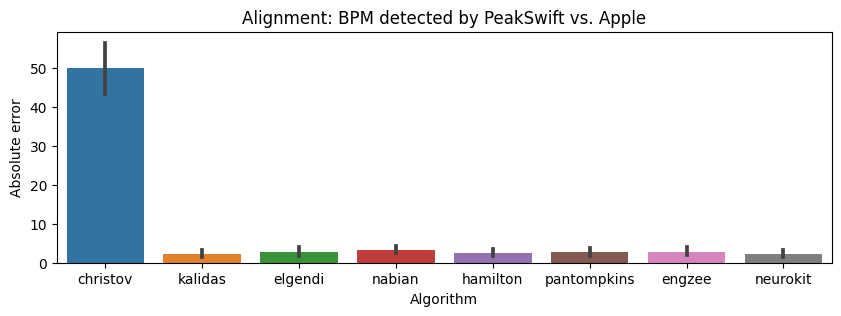

In [31]:
fig = plt.figure(figsize=(10,3))
ax = sns.barplot(data=result_table, x="algorithm", y="bpm_difference_rr")
ax.set(xlabel='Algorithm', ylabel='Absolute error')
ax.set_title('Alignment: BPM detected by PeakSwift vs. Apple')
plt.show()
fig.savefig('./results/comparisonBPM.png', bbox_inches='tight', dpi=300)
plt.close()

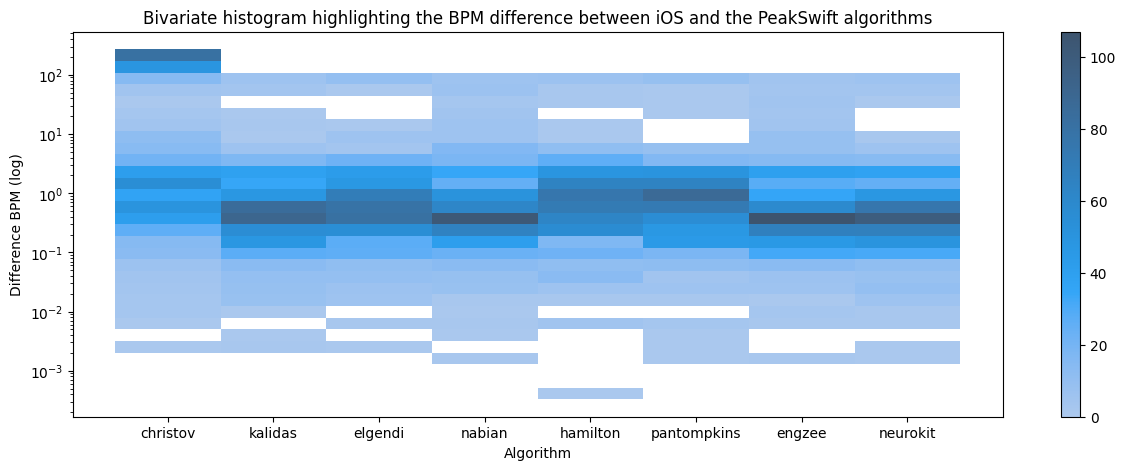

In [32]:
fig = plt.figure(figsize=(15,5))
ax = sns.histplot(
    result_table, x="algorithm", y="bpm_difference_rr",
    bins=30, discrete=(True, False), log_scale=(False, True),
    cbar=True,
)
ax.set(xlabel='Algorithm', ylabel='Difference BPM (log)')
ax.set_title("Bivariate histogram highlighting the BPM difference between iOS and the PeakSwift algorithms")
#Comparison of iOS and PeakSwift's algorithms for calculating the BPM.
plt.show()
fig.savefig('./results/histogramBPM.png', dpi=300, bbox_inches='tight')
plt.close()

### Computational Runtime

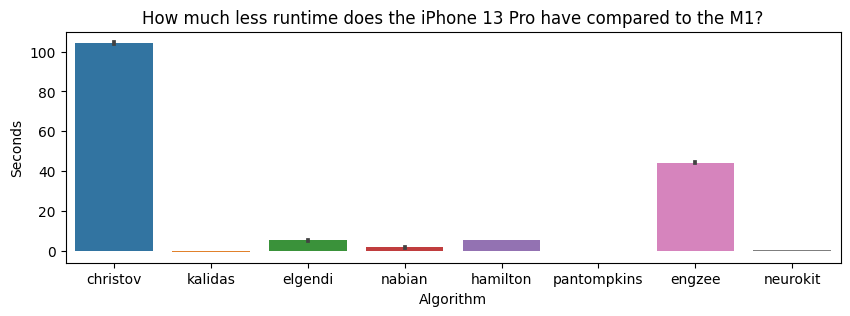

In [33]:
fig = plt.figure(figsize=(10,3))
ax = sns.barplot(data=result_table, x="algorithm", y="runtime_difference")
ax.set(xlabel='Algorithm', ylabel='Seconds')
ax.set_title('How much less runtime does the iPhone 13 Pro have compared to the M1?')
plt.show()
fig.savefig('./results/comparisonRuntime.png', bbox_inches='tight', dpi=300)
plt.close()

In [59]:
print('Self Recorded: How much faster on average is PeakSwift in Comparison to NeuroKit:', np.round(np.mean(result_table.swift_faster),2))
print('Open Source: How much faster on average is PeakSwift in Comparison to NeuroKit:', np.round(np.mean(result_table_os.swift_faster),2))
print('Combined: How much faster on average is PeakSwift in Comparison to NeuroKit:', np.round(np.mean(pd.concat([result_table.swift_faster, result_table_os.swift_faster])),2))

Self Recorded: How much faster on average is PeakSwift in Comparison to NeuroKit: 13.05
Open Source: How much faster on average is PeakSwift in Comparison to NeuroKit: 14.96
Combined: How much faster on average is PeakSwift in Comparison to NeuroKit: 14.88


In [35]:
result_table.groupby('algorithm')[['swift_faster']].agg(np.mean)

,swift_faster
algorithm,
christov,23.709361
elgendi,10.096247
engzee,49.373384
hamilton,15.741985
kalidas,0.896178
nabian,1.222869
neurokit,1.985063
pantompkins,1.569326


In [36]:
result_table_os.groupby('algorithm')[['swift_faster']].agg(np.mean)

,swift_faster
algorithm,
christov,27.525108
elgendi,14.769704
engzee,34.850876
hamilton,29.209571
kalidas,2.419273
nabian,1.637756
neurokit,4.923015
pantompkins,4.713927


### Real-Time Capabilities

In [37]:
result_table.groupby(['algorithm', 'real_time_capabilities_bool'])['id'].count()

algorithm    real_time_capabilities_bool
christov     True                           509
elgendi      True                           509
engzee       True                           506
hamilton     True                           509
kalidas      True                           509
nabian       True                           509
neurokit     True                           509
pantompkins  True                           509
Name: id, dtype: int64

In [38]:
result_table_os.groupby(['algorithm', 'real_time_capabilities_bool'])['id'].count()

algorithm    real_time_capabilities_bool
christov     True                           10555
elgendi      True                           10555
engzee       True                           10375
hamilton     True                           10555
kalidas      True                           10555
nabian       True                           10555
neurokit     True                           10554
pantompkins  True                           10555
Name: id, dtype: int64

## F1 scores, Recall, Precision

In [119]:
def calculcate_precision(result_table):
    return result_table['tp'] / (result_table['tp'] + result_table['fp'])

def calculcate_recall(result_table):
    return result_table['tp'] / (result_table['tp'] + result_table['fn'])

def calculcate_f1(result_table):
    return 2 * result_table['precision'] * result_table['recall']  / (result_table['precision'] + result_table['recall'])

In [120]:
def calculate_precision_recall_per_algorihtm(results):
    return calculate_precision_recall(results.groupby(['algorithm']))

In [125]:
def calculate_precision_recall(results):
    result_with_scores = results[['tp', 'fp', 'fn']].sum()#.agg({'tp':'sum','fp':'sum', 'fn': 'sum'})
    result_with_scores['precision'] = calculcate_precision(result_with_scores)
    result_with_scores['recall'] = calculcate_recall(result_with_scores)
    result_with_scores['f1'] = calculcate_f1(result_with_scores)
    return result_with_scores

In [128]:
res = calculate_precision_recall(result_table_os)
print(
    'F1 (Total)',
    res['f1'],
    'Precision (Total)',
    res['precision'],
    'Recall (Total)',
    res['recall'],
)

F1 (Total) 0.9982534571300373 Precision (Total) 0.9982809686173424 Recall (Total) 0.9982259471590611


In [127]:
calculate_precision_recall_per_algorihtm(result_table_os)

,tp,fp,fn,precision,recall,f1
algorithm,,,,,,
christov,166902,7,8,0.999958,0.999952,0.999955
elgendi,146260,498,490,0.996607,0.996661,0.996634
engzee,106029,78,66,0.999265,0.999378,0.999321
hamilton,169295,215,169,0.998732,0.999003,0.998867
kalidas,151700,0,0,1.000000,1.000000,1.000000
nabian,120967,0,0,1.000000,1.000000,1.000000
neurokit,139936,1084,1235,0.992313,0.991252,0.991782
pantompkins,158034,114,92,0.999279,0.999418,0.999349
